In [1]:
import pystan
from pystan import StanModel
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from psis import psisloo
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.utils import resample

In [2]:
projects = pd.read_csv("projects.csv", header=None)
display(HTML(projects.head(100).to_html(max_rows=100)))

/Users/juliushietala/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,NaN,NaN,NaN,NaN
1,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
2,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000,2017-09-02 04:43:57,2421,failed,15,US,100,NaN,NaN,NaN,NaN
3,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
4,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
5,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
6,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN
7,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 18:30:44,1000,2014-12-01 18:30:44,1205,successful,16,US,1205,NaN,NaN,NaN,NaN
8,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17 19:05:12,25000,2016-02-01 20:05:12,453,failed,40,US,453,NaN,NaN,NaN,NaN
9,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN


#### Run below cells after making changes

### Get the data

In [3]:
pm = np.array(projects) #All project data
pm = np.delete(pm, (0), axis=0) #Delete top row
pm = np.delete(pm, (0,1,2,3,4,5,7,11,12,13,14,15,16), axis=1) #Delete non needed columns

print(pm.shape) #Shape of the data


(378648, 4)


### Sanitize and display the data

In [4]:
success_idx = pm[:,2] == "successful" #Tuple of all indexes that are successful
failed_idx = pm[:,2] == "failed" #Tuple of all indexes that failed
print("Data points before processing: ",pm.shape[0])

#Remove all rows where the end result is not successful or failed
remove_idx = np.where(np.logical_or(success_idx,failed_idx)==False)
pm = np.delete(pm, remove_idx, axis=0)
print("Data points after removing non success/fail cases: ",pm.shape[0],"\n")

#Find new indexes for success and fail cases
success_idx = pm[:,2] == "successful"
failed_idx = pm[:,2] == "failed"

#Replace failed values with 0, success with 0 and convert whole matrix to numeric values
pm[success_idx,2] = 1
pm[failed_idx,2] = 0
pm = pm.astype(float)
pm = pm.astype(int)

#Remove all rows where the data points are below a threshold
remove_idx = np.where(pm[:,3] < 10)
pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,0] > 100000)
#pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,0] < 50000)
#pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,1] > 100000)
#pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,1] < 50000)
#pm = np.delete(pm, remove_idx, axis=0)

unique_backers_count = np.unique(pm[:,3]).shape[0] #Unique backers amount count
evaluated_projets = pm.shape[0] #All projects evaluated

print("Data points after removing data not falling to minimum threshold: ",evaluated_projets)


pd.DataFrame(pm).to_csv("sanitized.csv",header=False, index=False)
sanitized = pd.read_csv("sanitized.csv", header=None, names=["Goal","Pledged","Success","Backers"])
display(HTML(sanitized.head(100).to_html(max_rows=100)))

Data points before processing:  378648
Data points after removing non success/fail cases:  331033 

Data points after removing data not falling to minimum threshold:  186228


,Goal,Pledged,Success,Backers
0,30000,2421,0,15
1,50000,52375,1,224
2,1000,1205,1,16
3,25000,453,0,40
4,12500,12700,1,100
5,5000,94175,1,761
6,2500,664,0,11
7,1500,395,0,16
8,3000,789,0,20
9,5000,1781,0,40


### Scale down the data

### Format the data to be inserted in the model

In [5]:
groups, indices, inverse, group_amounts= np.unique(pm[:,3], return_index=True, return_inverse=True, return_counts=True) 

success_per_group = np.zeros((unique_backers_count,1)) #Empty array for success amounts per unique group
success_column = pm[:,2] #Column where the success/fail values live

group_means = np.zeros((unique_backers_count,1))
group_stds = np.zeros((unique_backers_count,1))

In [6]:
for i in range(evaluated_projets):
    if (success_column[i]==1): #Check whether a particular project has succeeded
        success_per_group[inverse[i]] = success_per_group[inverse[i],0] + 1 #If yes, increment the success amount of the group


In [7]:
for i in range(unique_backers_count):
    ind = np.where(pm[:,3] == groups[i])
    
    group_means[i] += np.mean(pm[ind,0])
    group_stds[i] += np.std(pm[ind,0])
    

In [8]:
#group_log_values = np.log(groups) #Backer counts in the log scale as we are using binomial logit
#success_int = success_per_group.astype(int)


s = np.asarray(pm[:,3]) # Backers / supporters
g = np.asarray(pm[:,0]) # Goal
p = np.asarray(pm[:,1]) # Pledged
y = np.asarray(pm[:,2]) # Success

N = pm.shape[0] # Size of data
n = np.asarray(np.ones((N,1))[:,0]).astype(int) # Projects per group, always = 1


project_stan_data = {
    's':np.log(s),
    'g':np.log(g),
    'y':y,
    
    'N': N,
    'n': n
}

### Data analysis before fitting model

In [9]:
pm = resample(pm,n_samples=1000,random_state=0)

Backer counts histogram
183.997
545.3570765938588


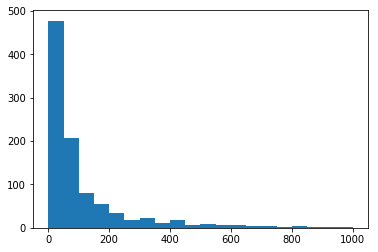

In [10]:
plt.hist(pm[:,3],bins=20, range=[0,1000]);
print("Backer counts histogram")
print(np.mean(pm[:,3]))
print(np.std(pm[:,3]))

Project goals histogram


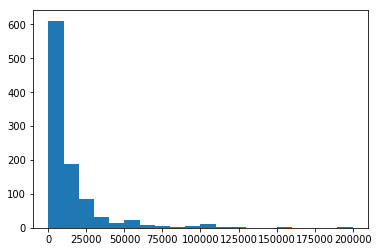

In [11]:
goals = pm[:,0]
print("Project goals histogram")
plt.hist(goals, bins=20,range=[0,200000]);

Projects pledged histogram


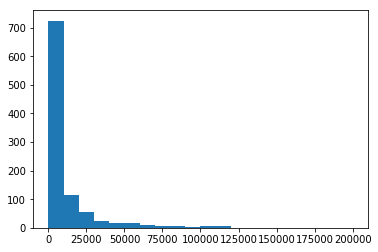

In [12]:
pledged = pm[:,1]
print("Projects pledged histogram")
plt.hist(pledged, bins=20,range=[0,200000]);

In [13]:
print(pm.shape)

(1000, 4)


### Define the model

In [14]:
stan_content = """

data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] s; // backers
    vector [N] g; // goal
    int y[N]; // success

}

parameters {
    real a;
    real b;
    real c;
    
  

}

model {
    b ~ normal(180,600);
    y ~ binomial_logit(N, a + b*s + c*g );
}

generated quantities {
  vector[N] log_lik;
  
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + b*s[i] + c*g[i]);
  }
}


"""

stan_file_sepa = open("model.stan", "w")
stan_file_sepa.write(stan_content)
stan_file_sepa.close()

### Fit the data to the model and print summary

In [ ]:
model = pystan.StanModel(file='model.stan')
fit = model.sampling(data=project_stan_data)
samples = fit.extract(permuted=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_954a7d49a967e3764bc28c86cfbeb9f1 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Amount of backers needed to succeed with 75% probability

In [28]:
a_samples = samples['a']
b_samples = samples['b']
c_samples = samples['c']


goal_log = np.log(100000)



prob = np.exp((2.19-alpha_samples) / beta_samples)*goal #Distribution when the probability of success is 90%
plt.hist(prob);

KeyError: 'd'

### PSIS-LOO analysis

In [29]:
print("PSIS-LOO value is", psisloo(samples['log_lik'])[0])

PSIS-LOO value is -12233.360907298413



 k-values plotted


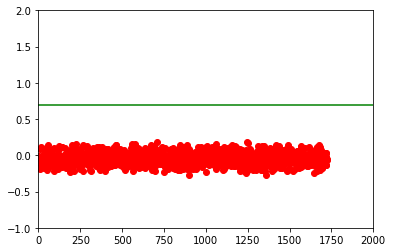

In [201]:
print("\n k-values plotted")
plt.plot(psisloo(samples['log_lik'])[2],'ro')
plt.axis([0, 2000, -1, 2])
plt.axhline(0.7, color='g');